# Bolivian Musicians - Artist Segmentation

### Overview
Bolivian musicians are very talented but unfortunately not many people know it. This data-based project aims to promote bolivian artists and make them more visible for locals and the world.

The project consists in:
- The construction of a dataset of bolivian artists by fetching public Spotify data.

- The application of data clustering techniques to segment the collected data and gain
  artists description.
- The implementation of a web app for data visualization and knowledge-based artist recommendations.


### Problem Statement
After I searched in the web, I could not find a dataset of bolivian artists. Hence, I had to build one from scratch. As far as I know this is the first dataset of Bolivian artists. The details of the data collection are [here](https://github.com/leanguardia/bolivian-music#dataset-construction).

By nature music is very varied and artists are even more. Artists can be very diverse or stick to one genre of music. There are traditional, new, trending artists with different targeted listeners. For this matter, a number of unsupervised learning techniques are applied and evaluated to perform artists segmentation. The expected outcome is to gain deeper understanding of the data and use it the organize the knowledge recommendation system.

This notebook contains:
- Data Analysis
- Artist Clustering
- Result Evaluation
- Conclusions and Recommendations

### Metrics
- Number of Partitions: A number of partitions will be tested.
- Error Score: The configuration with less error score will be picked.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
%matplotlib inline

In [2]:
df = pd.read_csv('data/artists_flitered.csv')
df.shape

(204, 5)

In [3]:
df.head()

,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"


## Analysis
### Data Exploration

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   artist_id   204 non-null    object
 1   name        204 non-null    object
 2   popularity  204 non-null    int64 
 3   followers   204 non-null    int64 
 4   genres      204 non-null    object
dtypes: int64(2), object(3)
memory usage: 8.1+ KB


In [5]:
quantitative_cols = ['popularity', 'followers']
desc = df[quantitative_cols].describe()
desc

,popularity,followers
count,204.000000,204.000000
mean,18.215686,2923.656863
std,12.370812,8559.691106
min,0.000000,0.000000
25%,8.000000,204.750000
50%,17.000000,722.500000
75%,28.000000,2087.250000
max,56.000000,97077.000000


In [6]:
qualitative_cols = [col for col in df.columns if col not in quantitative_cols]
df[qualitative_cols].describe()

,artist_id,name,genres
count,204,204,204
unique,204,204,26
top,4Ndmj2D1NcPFkJG4hqBPhO,Consagrados,[]
freq,1,1,36


#### Missing Values

In [7]:
df.isna().sum()

artist_id     0
name          0
popularity    0
followers     0
genres        0
dtype: int64

**Note:** Despite the first 4 columns not having any missing values. The `genre` column should be treated differently becuase it represents a list. Because there are stored as string, counting missing values should be treated differently:

In [8]:
no_genres = df[df.genres == '[]']
print(f"There are {no_genres.shape[0]} / {df.shape[0]} artists with no genres associated")

There are 36 / 204 artists with no genres associated


#### Duplicated values

In [9]:
# Duplicates by id or name.
df[df.duplicated('artist_id') | df.duplicated('name')]

,artist_id,name,popularity,followers,genres


**Note:** Duplicates were removed in data collection stage in `data/artists_eda` notebook.

### Data Visualization
#### Popularity

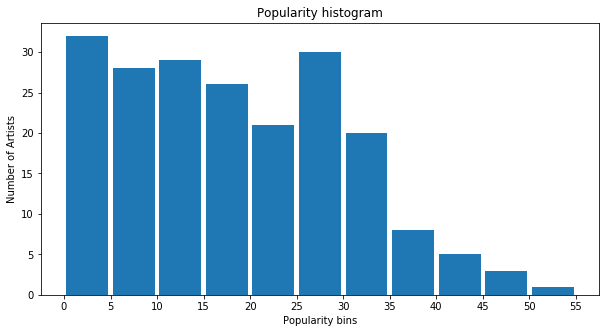

In [10]:
bins = np.arange(0, 60, 5)
ax = df.popularity.plot.hist(bins=bins, rwidth=0.9, figsize=(10,5));
ax.set_xlabel('Popularity bins'); ax.set_ylabel('Number of Artists'); 
ax.set_title('Popularity histogram')
plt.xticks(bins, bins);

Bimodal distribution skewed to the right. Half of the data has 17 points of popularity or less.

In [11]:
df.sort_values('popularity', ascending=False).head(10)

,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
6,0SWtMcmZLgP04Kj5x0eCxa,azul azul,50,16351,['latin pop']
33,3U5KZkwiSmACysZTJIvjgU,Grupo Veneno,48,3676,['cumbia boliviana']
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"
9,1pbcskpK1qePXm3sYvYu4o,Chila Jatun,42,14970,['andean']
8,1IYPsxunWpJvDYA1Por8dI,Diego Ríos,41,15293,['cumbia boliviana']
12,4EBLOxVwhNdq0BbTy0M6xN,Llajtaymanta,40,9818,"['andean', 'folklore boliviano', 'huayno']"


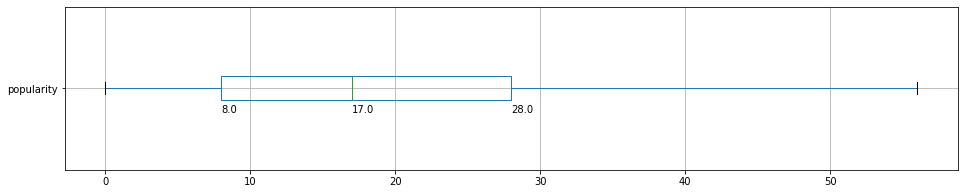

In [12]:
ax = df.boxplot(column='popularity', vert=False, figsize=(16,3));
ax.annotate(df.popularity.median(), (df.popularity.median(), 0.85))
ax.annotate(desc.popularity['25%'], (desc.popularity['25%'], 0.85))
ax.annotate(desc.popularity['75%'], (desc.popularity['75%'], 0.85));

No outliers found.

#### Followers

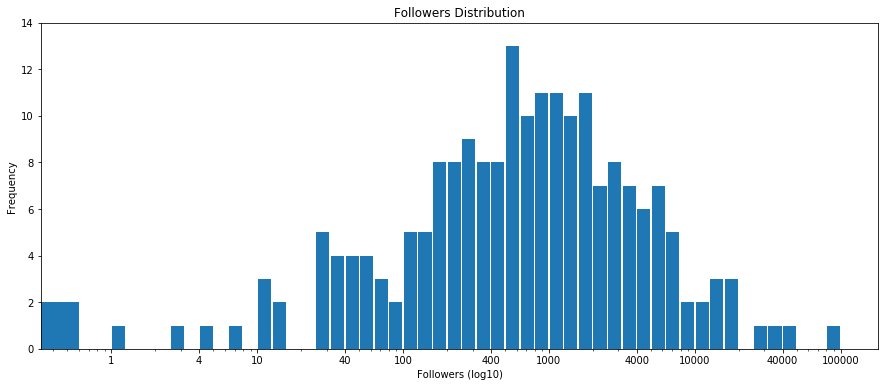

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(15,6))
plt.xscale('log')

positive_followers = df.followers[df.followers > 0]
no_followers = df[df.followers == 0].shape[0]
positive_followers_log = np.log10(positive_followers)

bin_edges = 10 ** np.arange(0, positive_followers_log.max()+0.1, 0.1)
ax.hist(positive_followers, bins=bin_edges, rwidth=0.90)
plt.bar(0.1, no_followers, width = 1)

xticks = [1,4,10, 40, 100, 400, 1000, 4000, 10000, 40000, 100000]
plt.xticks(xticks, xticks)
yticks = np.arange(0, 16, 2)
plt.yticks(yticks, yticks)
plt.title("Followers Distribution")
plt.ylabel("Frequency")
plt.xlabel("Followers (log10)");

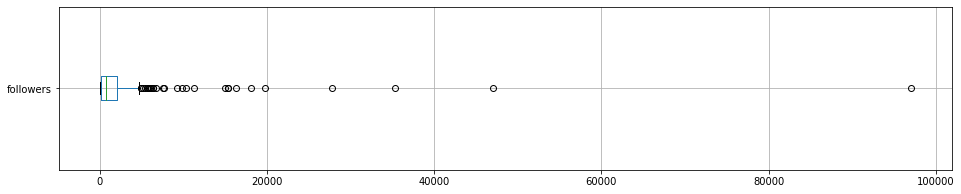

In [14]:
# Outliers
ax = df.boxplot(column='followers', vert=False, figsize=(16,3));

In [15]:
Q1 = desc.followers['25%']
Q3 = desc.followers['75%']
IQR = Q3 - Q1
followers_limit = Q3 + 1.5 * IQR

outliers = df[(df.followers >= followers_limit)]
print("Outliers:", outliers.shape[0], '/', df.shape[0], "elements with more than", followers_limit, 'followers.')
outliers.head()

Outliers: 28 / 204 elements with more than 4911.0 followers.


,artist_id,name,popularity,followers,genres
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"['andean', 'charango', 'folklore boliviano']"
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,['hip hop boliviano']
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"['cumbia boliviana', 'pop reggaeton']"
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"['andean', 'folklore boliviano']"
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"['andean', 'folklore boliviano']"


(176, 5)


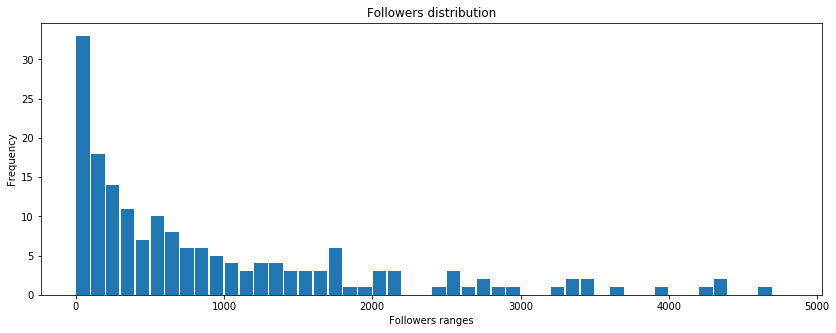

In [16]:
def remove_outliers(df):
    Q1 = df.followers.quantile(.25)
    Q3 = df.followers.quantile(.75)
    IQR = Q3 - Q1
    followers_limit = Q3 + 1.5 * IQR
    return df[df.followers <= followers_limit]
non_outliers = remove_outliers(df)
print(non_outliers.shape)
ax = non_outliers.followers.plot.hist(rwidth=0.9, bins=np.arange(0,4800+100,100), figsize=(14,5))
ax.set_title('Followers distribution'); ax.set_xlabel("Followers ranges");

#### Popularity and Followers

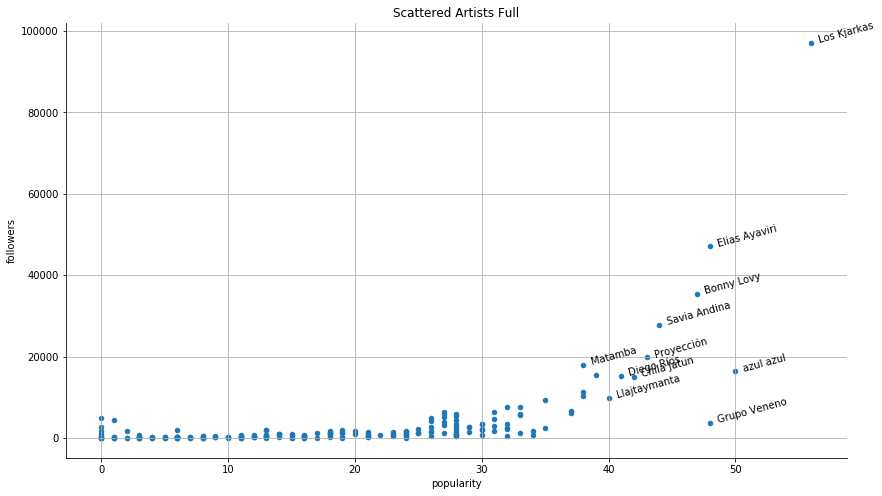

In [17]:
ax = df.plot.scatter(x='popularity', y='followers', figsize=(14,8))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
popularity_thrs = 40
followers_thrs = 18000
top_artists = df[(df.popularity >= popularity_thrs) | (df.followers >= followers_thrs)]

for i, row in top_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.5, row['followers']), rotation=15)
ax.set_title("Scattered Artists Full");

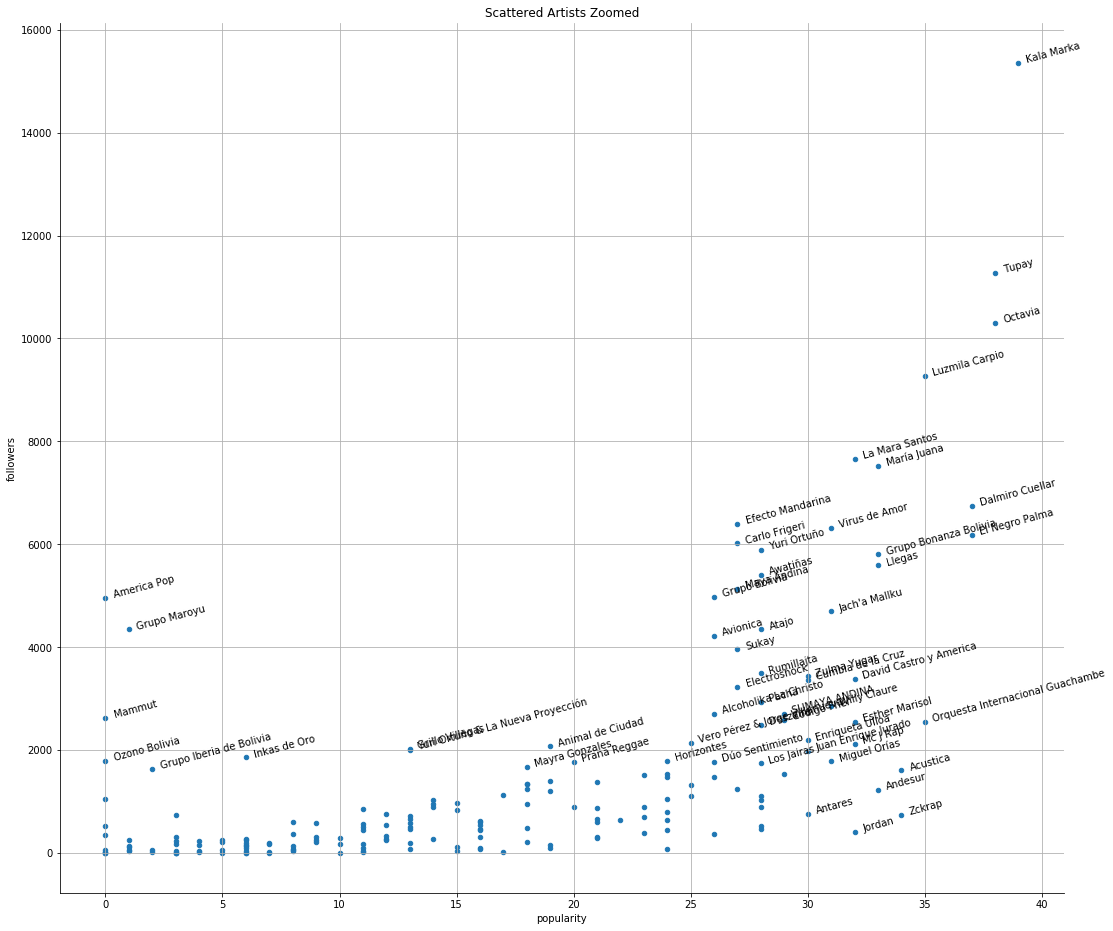

In [18]:
# Zoomed Plot
zoomed_artists = df[(df.popularity < popularity_thrs) & (df.followers < followers_thrs)]
ax = zoomed_artists.plot.scatter(x='popularity', y='followers', figsize=(18,16))
ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid()
ax.set_title("Scattered Artists Zoomed 2X");

mid_artists = zoomed_artists[(zoomed_artists.popularity >= 30) | (zoomed_artists.followers >= 1600)]
for i, row in mid_artists.iterrows():
    ax.annotate(row['name'], (row['popularity']+0.3, row['followers']), rotation=15)
ax.set_title("Scattered Artists Zoomed");

#### Genres

Number of genres: 19


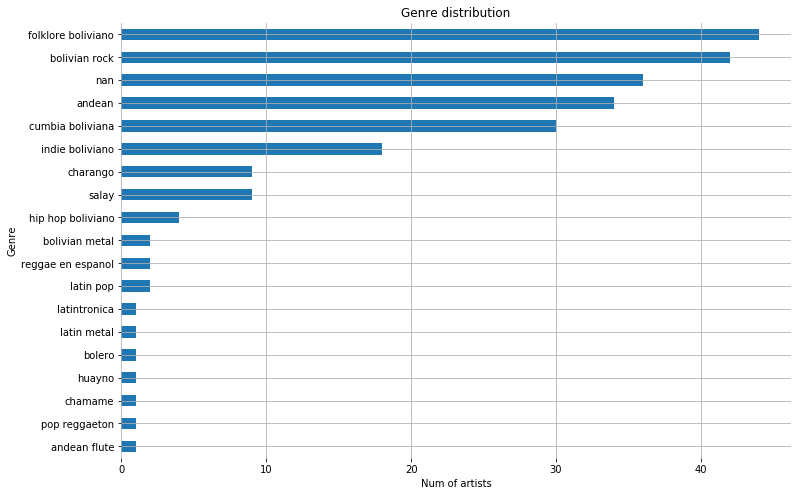

In [19]:
df.genres = df.genres.apply(literal_eval)
def plot_genre_dist(df):
    exploded = df.genres.explode()
    print("Number of genres:", len(exploded.unique()))
    ax = exploded.value_counts(dropna=False).sort_values(ascending=True).plot.barh(figsize=(12,8))
    ax.set_xlabel('Num of artists'); ax.set_ylabel('Genre'); ax.set_title('Genre distribution');
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False);
plot_genre_dist(df)

/Users/delgard/opt/miniconda3/lib/python3.7/site-packages/pandas/core/generic.py:5302: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Number of genres: 16


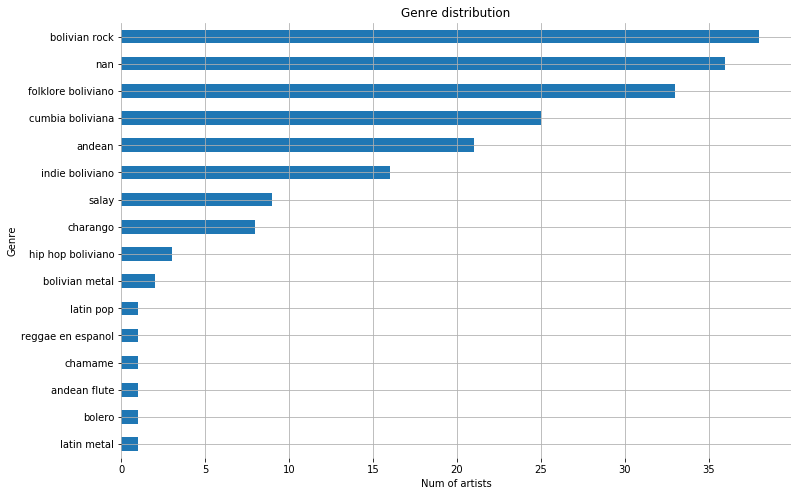

In [20]:
non_outliers['genres'] = non_outliers.genres.apply(literal_eval)
plot_genre_dist(non_outliers)

Removing outliers results in loosing 24 artists and 4 genres.

## Methodology

### Data Preprocessing

The `genres` column contains a list of genres. These will be split in dummy columns to represent wheter an artist is labeled with a genre `1` or not `0`.

In [21]:
genres = pd.Series(df.genres.explode().unique())
genres = genres.replace(np.nan, 'NaN').tolist()
genres

['andean',
 'charango',
 'folklore boliviano',
 'hip hop boliviano',
 'cumbia boliviana',
 'pop reggaeton',
 'bolivian rock',
 'reggae en espanol',
 'latin pop',
 'huayno',
 'latintronica',
 'indie boliviano',
 'bolivian metal',
 'salay',
 'bolero',
 'andean flute',
 'chamame',
 'NaN',
 'latin metal']

**Note:** In this case it makes sense to include `NaN` values to the model. There might be artists which genre was not assigned by  Spotify for a specific reason. E.g. low popularity.

In [22]:
# Create a container to fill dummy variables
zeroes = np.zeros((df.shape[0], len(genres)))
dummies = pd.DataFrame(zeroes, columns=genres, index=df.index, dtype=int)

# Fill dummy variables for each genre in the list.
for i, artist_genres in enumerate(df.genres):
        indices = np.unique(dummies.columns.get_indexer(artist_genres))
        dummies.iloc[i, indices] = 1

# Merge dummies to df
df_model = pd.concat([df, dummies], axis=1)
df_model.head()

,artist_id,name,popularity,followers,genres,andean,charango,folklore boliviano,hip hop boliviano,cumbia boliviana,...,huayno,latintronica,indie boliviano,bolivian metal,salay,bolero,andean flute,chamame,NaN,latin metal
0,0tkboyBYNymYytYlb9EXkN,Los Kjarkas,56,97077,"[andean, charango, folklore boliviano]",1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,30DQw23SjsbMLFlhia84jN,Elias Ayaviri,48,47069,[hip hop boliviano],0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2oM7LqPaoCUcHHHnsTtgn1,Bonny Lovy,47,35314,"[cumbia boliviana, pop reggaeton]",0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0hkFv9719WLJ2uupZTn0ru,Savia Andina,44,27731,"[andean, folklore boliviano]",1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,119DPASXtwEkIiAoRSOUR8,Proyección,43,19783,"[andean, folklore boliviano]",1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


### Implementation

In [23]:
from sklearn.cluster import KMeans
import numpy as np

def plot_clusters(dataframe, clusters):
    cluster_series = pd.Series(clusters, name="cluster", dtype=int, index=dataframe.index)
    df_clusters = pd.concat([dataframe, cluster_series], axis=1)
    k = len(pd.unique(clusters))
    fig, ax = plt.subplots(figsize=(12,7))
    sns.scatterplot(data=df_clusters, x='popularity', y='followers', hue='cluster', ax=ax, palette="tab20")

    ax.set_title("Artist Segmentation (k={})".format(k)); ax.set_xlabel('popularity')
    ax.spines['right'].set_visible(False); ax.spines['top'].set_visible(False); plt.grid();
    return df_clusters
    
def segment_data(X, k):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    clusters = kmeans.labels_
    return kmeans, clusters

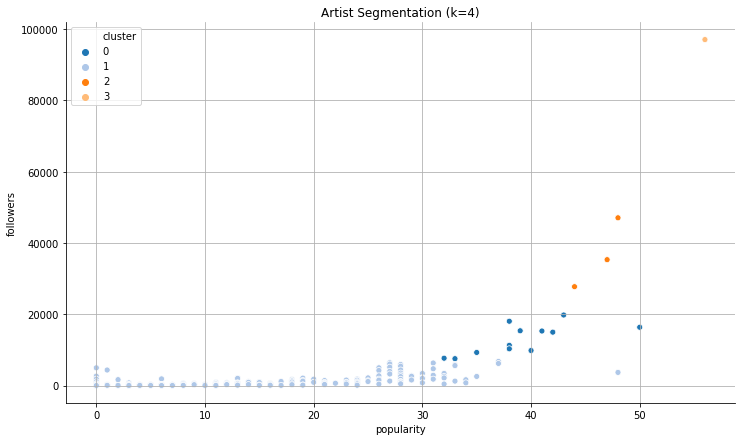

In [35]:
features = ['popularity', 'followers'] + genres
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

In [25]:
kmeans.cluster_centers_[:, :2]

array([[3.90833333e+01, 1.29711667e+04],
       [1.62340426e+01, 1.24245213e+03],
       [4.63333333e+01, 3.67046667e+04],
       [5.60000000e+01, 9.70770000e+04]])

**Note:** The Previous segmentation is manly using followers data since the features have not been scaled. `KMeans` uses Euclidean Distance to measure similarity between data poits, therefore, data needs to be scaled before fitting. (Data Engineering Lesson Nanodegree). 

#### Scaling Features

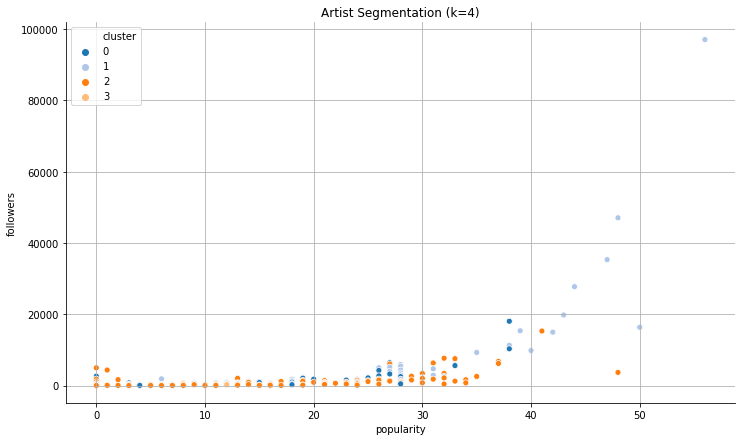

In [26]:
from sklearn.preprocessing import scale

genres_std = [genre + ' std' for genre in genres]
dummies_std = pd.DataFrame(scale(dummies), columns=genres_std)

df_model = pd.concat([df_model, dummies_std], axis=1)
features = ['popularity_std', 'followers_std'] + genres_std
kmeans, clusters = segment_data(df_model[features], k=4)
_ = plot_clusters(df_model, clusters)

Now, Kmeans found groups based in popularity, followers, 20 possible music genres, and one the absense of genre. Next, the correct number of clusters.


### Define the number of Clusters
Kmeans is an unsupervised learning technique for data clustering. For this technique it is necessary to define the number of clusters (`k`). In some cases [domain knowledge](https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a) is enough. However, in this work the elbow method will be used.

#### Elbow Method

Consists in running the clustering algorithm for a list of numbers of clusters, find the smallest `k` with less decrease of `wcss` (within cluster squared sums) in the skree plot (the elbow), that is a potential good `k`.

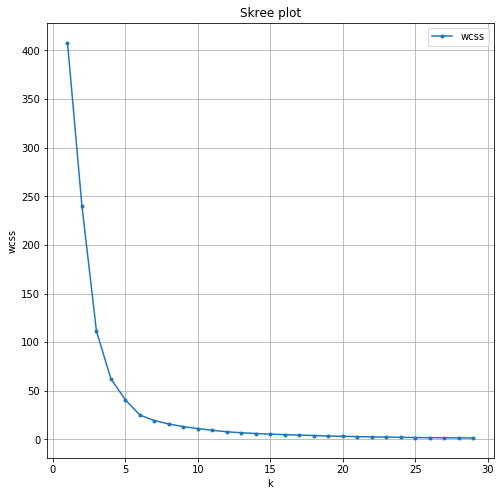

In [36]:
# Analysis 1: popularity and followers
features = ['popularity_std', 'followers_std']
clusters_list = np.arange(1,30)
wcss = []
labels = []
X = df_model[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

def plot_skree(clusters_list, wcss):
    clusters_res = pd.DataFrame({'k': clusters_list, 'wcss': wcss})
    ax = clusters_res.plot(x='k', y='wcss', marker='.', figsize=(8,8))
    ax.set_title('Skree plot'); ax.set_ylabel('wcss'); plt.grid()
plot_skree(clusters_list, wcss)

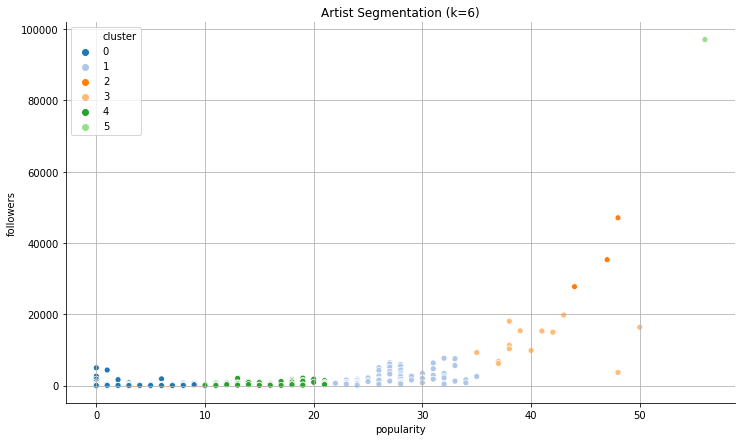

In [37]:
num_of_clusters = 6
clusters = labels[num_of_clusters-1]
df_clusters = plot_clusters(df_model, clusters)

From left to right: the first three groups look could be labeled as emergent artists with increasing popularity. The folowing groups could be labeled as popular artists because of both, their popularity and number of followers, which seem to have a linear correlation. This assignation could be 5 and include the top datapoint to the top group.

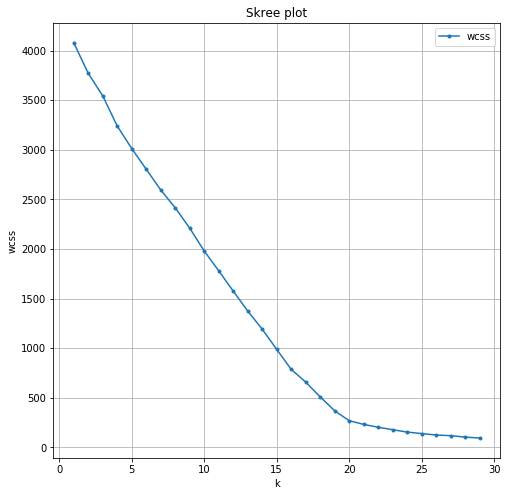

In [27]:
# Analysis 2: popularity, followers and genres
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
X = df_model[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

Interestingly enough the appropriate number of clusters increases to 20 when genres are added.

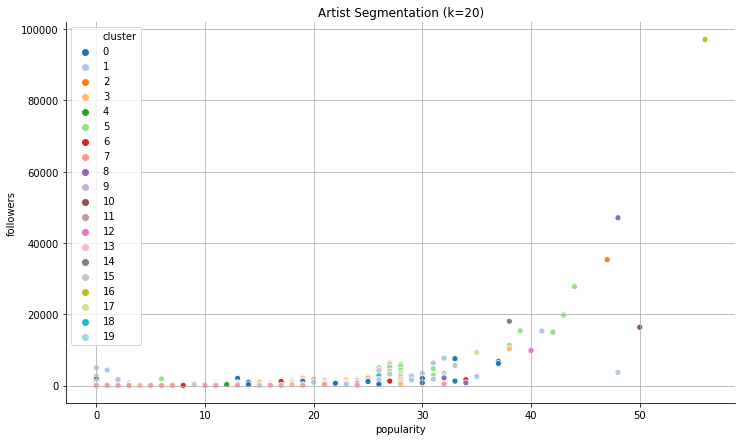

In [28]:
num_of_clusters = 20
clusters = labels[num_of_clusters-1]
df_clusters = plot_clusters(df_model, clusters)

Since the outliers make this graphic too difficul to interpret, the same analysis will be made below with the subset with no outliers. However, a heatmap is plotted below to visualize the correlation between the genres and the clusters.

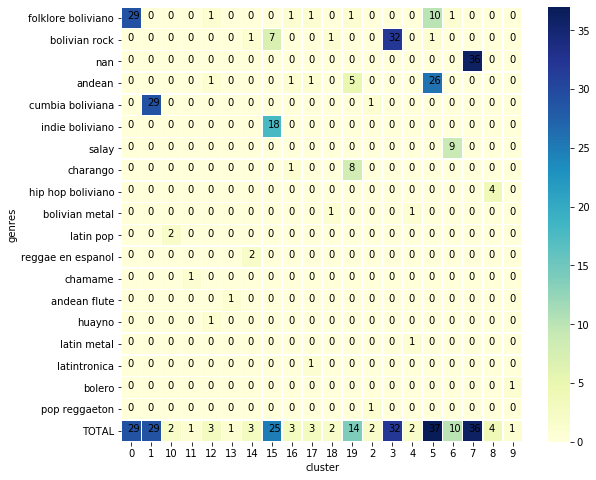

In [29]:
def plot_genre_cluster_map(df):
    genres_cluster = df.explode('genres').astype(str).groupby(['genres', 'cluster']) \
                        .count()['name'].astype(int).unstack(fill_value=0)
    genres_cluster['sum'] = genres_cluster.apply(sum, axis=1)
    genres_cluster = genres_cluster.sort_values(by='sum', ascending=False)
    genres_cluster = genres_cluster.drop(columns='sum')
    
    total_by_cluster = genres_cluster.apply(sum, axis=0)
    genres_cluster.loc['TOTAL'] = total_by_cluster

    fig, ax = plt.subplots(figsize=(9,8))
    sns.heatmap(genres_cluster, linewidth=0.5, cmap="YlGnBu", ax=ax);
    genres_cluster_vals = genres_cluster.values

    for row in range(genres_cluster_vals.shape[0]):
        for col in range(genres_cluster_vals.shape[1]):
            ax.annotate(genres_cluster_vals[row][col], (col+0.3, row+0.55))
plot_genre_cluster_map(df_clusters)

KMeans grouped artists by their music genders. Most of the clusters collected artists from specific genres exclusively, i.e. _chamame, andean flute, bolero, latin pop_ and _No Genre (nan)_. On the other side, some clusters contain pairs of genres such as 5 with _folklore_ and _andean_ which is related with 19 with _charango_ genre. Similarly, some instance of _rock_ and _indie_ have been grouped in cluster 15. The rest of the clusters clusters are underrepresented subgroups of the main groups.

Below the distribution between clusters and popularity and followers is shown.

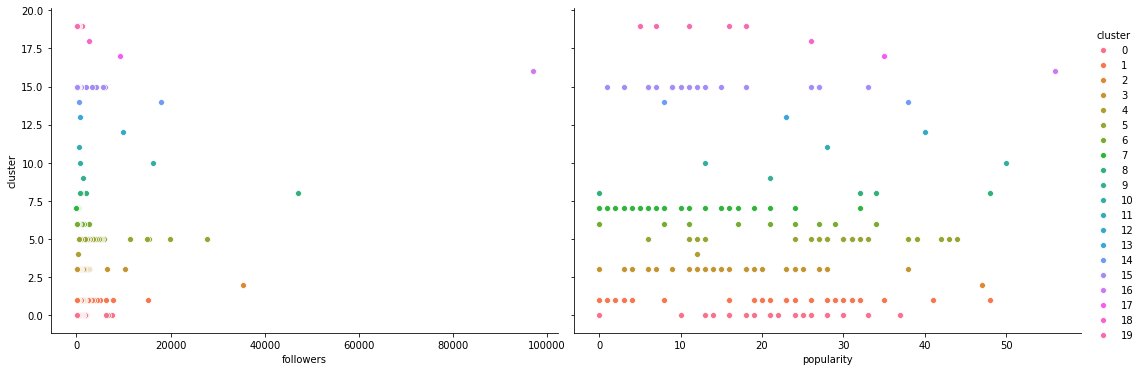

In [30]:
sns.pairplot(df_clusters, x_vars=["followers", "popularity"], y_vars=['cluster'], height=5, aspect=1.5, hue='cluster');

Again, it is difficult to find correlations for the followers distributions because of the outliers present. On the other side, the distribution between cluster and probability does not seem be strong. 

### Refinement
Since 20 clusters are too many groups. The elbow method is re-aplied after removing the outliers from the dataset.

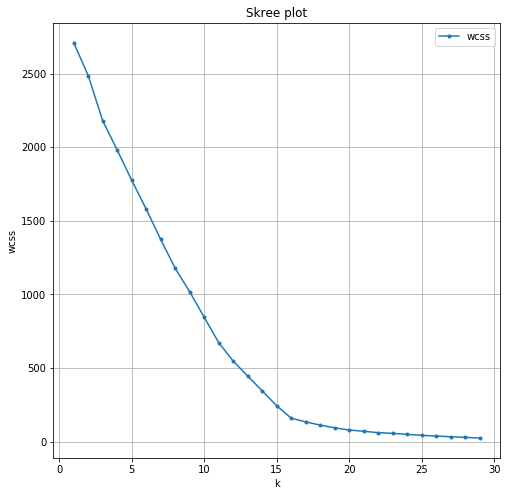

In [38]:
features = ['popularity_std', 'followers_std'] + genres_std
clusters_list = np.arange(1,30)
wcss = []
labels = []
non_outliers = remove_outliers(df_model)
X = non_outliers[features]

for k in clusters_list:
    kmeans, clusters = segment_data(X, k)
    wcss.append(kmeans.inertia_)
    labels.append(clusters)

plot_skree(clusters_list, wcss)

After removing the 24 outliers identified above, the data subset has now 16 genres, exactly the same number of apparent best number of clusters.

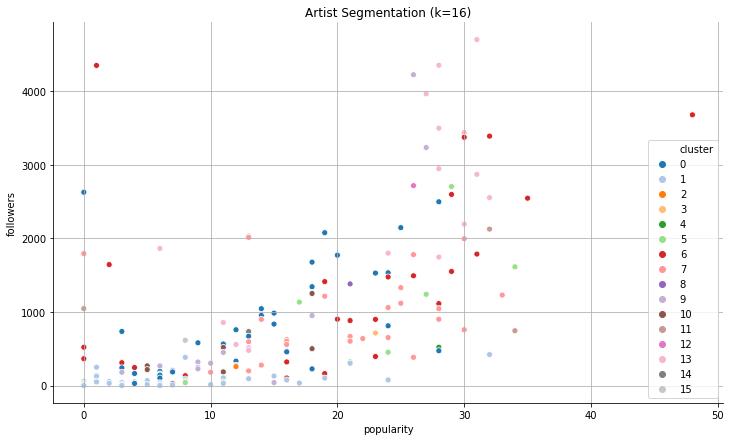

In [32]:
num_of_clusters = 16
clusters = labels[num_of_clusters-1]
df_clusters_reduced = plot_clusters(non_outliers, clusters)

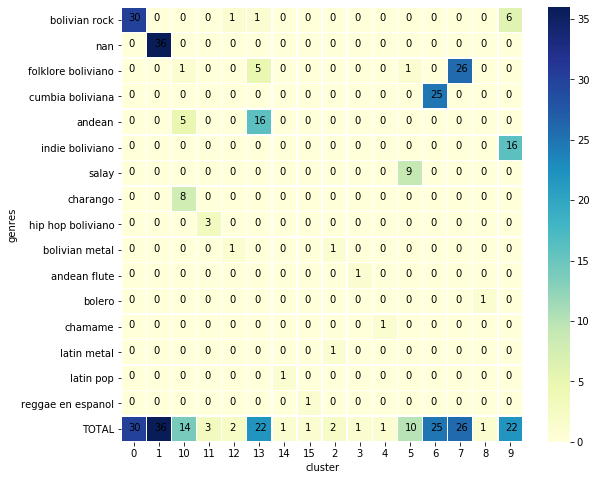

In [33]:
plot_genre_cluster_map(df_clusters_reduced)

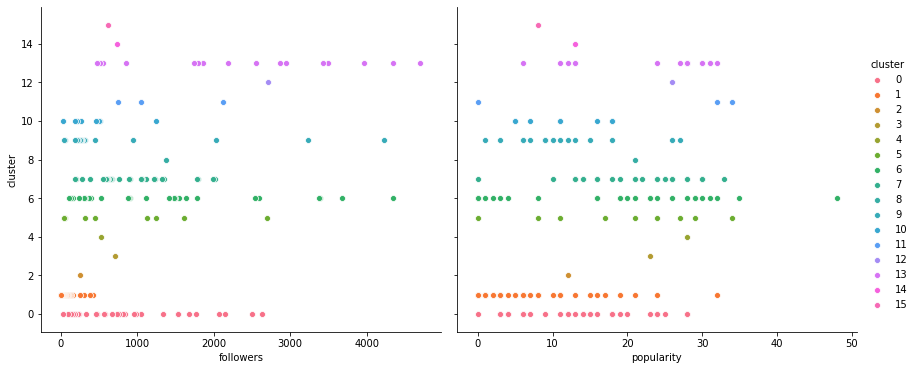

In [34]:
sns.pairplot(df_clusters_reduced, x_vars=["followers", "popularity"], y_vars=['cluster'], height=5, aspect=1.2, hue='cluster');

The segmentation of the subset of data looks similar regardless of the absence of outliers. No new information could be found in comparison with the segmentation of the full dataset. The final analysis is discussed in the following section.

## Results

### Model Evaluation

KMeans is an unsupervised learning algorithm. This means data is not labeled and no optimization or objective evaluation can be applied. However, after applying data transformations and searching for a sensible number of clusters, the following results have been met:
- Analysing followers and popularity data only results in three groups of unpopular artists and two groups of popular artists, they could be labeled `thriving` and `top` artists.
- When genrese data is included in the analysis, Kmeans groups artists by that feature and followers and popularity lose importance. Some clusters include different genres but they only model relations that are found in artists that have more than one genre i.e. `Kjarkas` with genres _folklore, andean_ and _charango_.

https://towardsdatascience.com/k-means-clustering-algorithm-applications-evaluation-methods-and-drawbacks-aa03e644b48a


### Justification

- KMenas was the only algorithm since the datset is small (200+ elements).
- `scale` was the only scaling method used because it is good for categorical data, in this case 20 columns of the data were categorical where a gender could be present or absent.

## Conclusion
### Reflection
Student adequately summarizes the end-to-end problem solution and discusses one or two particular aspects of the project they found interesting or difficult.

### Improvement
The following aspects of the project can be improved:
- Enrich artist data with dates for example when did the artist start releasing music and when was the last release. That information might help finding groups of new and traditional artists withing genres.
- Manually improving the quality of the genres and their overlaps might result in better subgrouping of genres. i.e. it is common that some artists fuse `raggae` and `rock` which are very different genres upront but these cases exist.